In [27]:
# Instalação das bibliotecas
!pip install tensorflow scikit-learn matplotlib scikeras

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
# Importações
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import load_img, img_to_array
from scikeras.wrappers import KerasClassifier
import tensorflow as tf


In [22]:
# Verificar se o tf está usando a GPU
print(tf.config.list_physical_devices('GPU'))

[]


In [29]:
# Carregar imagens 
def carregar_dados(base_path, tipo):
    X, y = [], []
    classes = os.listdir(base_path)
    for classe in classes:
        caminho = os.path.join(base_path, classe, tipo)
        if not os.path.isdir(caminho):
            continue
        for arquivo in os.listdir(caminho):
            img_path = os.path.join(caminho, arquivo)
            # imagem = load_img(img_path, target_size=(384, 512))
            imagem = load_img(img_path, target_size=(128, 128))
            img_array = img_to_array(imagem) / 255.0
            X.append(img_array)
            y.append(classe)
    return np.array(X), np.array(y)

In [30]:
# Carregar dataset de treinamento
dataset_path = 'dataset'
X_train, y_train = carregar_dados(dataset_path, 'treinamento')
X_test, y_test = carregar_dados(dataset_path, 'teste')

# Codificar labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# One-hot encoding
y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

# Shuffle
X_train, y_train_cat = shuffle(X_train, y_train_cat, random_state=42)

In [32]:
# Modelo da CNN
def criar_modelo(dropout_rate=0.3, n_classes=5):
    model = Sequential([
        # Conv2D(32, (3,3), activation='relu', input_shape=(384, 512, 3)),
        Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [33]:
# Cross-Validation (Ajuste dos hiperparâmetros)
early_stop = EarlyStopping(monitor='val_loss', patience=3)

modelo_cv = KerasClassifier(
    model=criar_modelo,  # ← com scikeras, use 'model=', não 'build_fn='
    verbose=0
)

param_grid = {
    'model__dropout_rate': [0.3, 0.4],
    # 'batch_size': [32, 64],
    'batch_size': [64, 128],
    'epochs': [10, 15]
}

grid = GridSearchCV(estimator=modelo_cv, param_grid=param_grid, cv=2)
grid_result = grid.fit(X_train, y_train_cat, callbacks=[early_stop])

print("Melhores hiperparâmetros:", grid_result.best_params_)

C:\Users\costa\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\costa\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\costa\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first

C:\Users\costa\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


C:\Users\costa\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\costa\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\costa\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first

Melhores hiperparâmetros: {'batch_size': 64, 'epochs': 15, 'model__dropout_rate': 0.4}


In [34]:
# Treinamento com os melhores hiperparâmetros
melhor_modelo = criar_modelo(dropout_rate=grid_result.best_params_['model__dropout_rate'])
melhor_modelo.fit(
    X_train, y_train_cat,
    epochs=grid_result.best_params_['epochs'],
    batch_size=grid_result.best_params_['batch_size'],
    verbose=1,
    validation_split=0.1
)

# Salvar modelo final
melhor_modelo.save("modelo_residuos.keras")

Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.2226 - loss: 3.2589 - val_accuracy: 0.3625 - val_loss: 1.4895
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.4199 - loss: 1.4150 - val_accuracy: 0.4437 - val_loss: 1.2924
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy: 0.5244 - loss: 1.2203 - val_accuracy: 0.4812 - val_loss: 1.2328
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.5492 - loss: 1.1265 - val_accuracy: 0.4875 - val_loss: 1.1755
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.6379 - loss: 0.9530 - val_accuracy: 0.5188 - val_loss: 1.1768
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.7081 - loss: 0.8213 - val_accuracy: 0.5188 - val_loss: 1.2649
Epoch 7/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.7522 - loss: 0.6793 - val_accuracy: 0.6187 - val_loss: 1.1433
Epoch 8/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 196ms/step - accuracy: 0.8361 - loss: 0.5099 - val_accuracy: 0.

In [35]:
# Teste
y_pred_prob = melhor_modelo.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

print("Relatório de Classificação:")
print(classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_))

# RMSE
rmse = np.sqrt(mean_squared_error(y_test_enc, y_pred))
print(f"RMSE: {rmse:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Relatório de Classificação:
              precision    recall  f1-score   support

       metal       0.55      0.70      0.62        80
       papel       0.78      0.70      0.74        80
     papelao       0.86      0.76      0.81        80
    plastico       0.76      0.65      0.70        80
       vidro       0.53      0.57      0.55        80

    accuracy                           0.68       400
   macro avg       0.70      0.68      0.68       400
weighted avg       0.70      0.68      0.68       400

RMSE: 1.4629


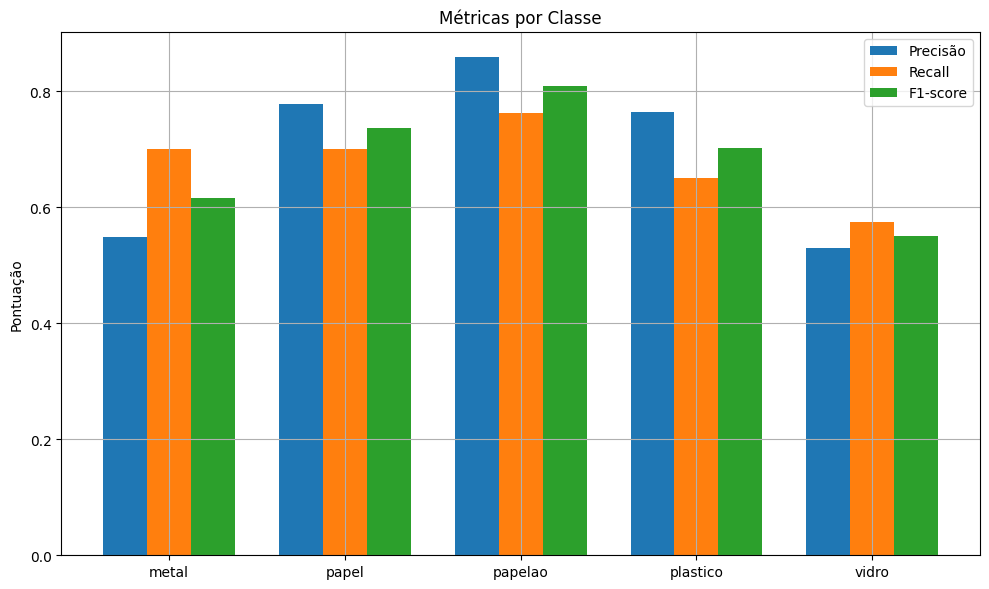

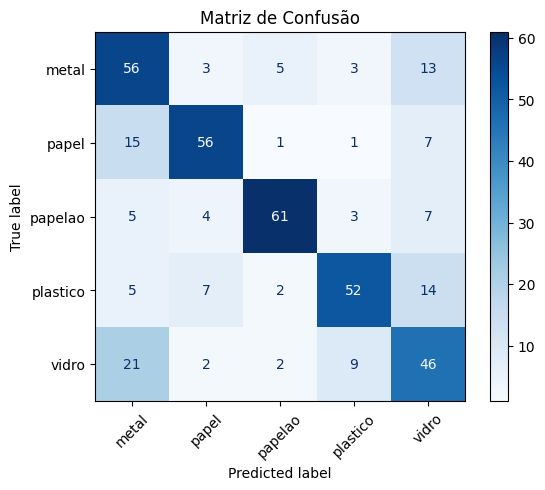

In [36]:
# Gráficos com as métricas de desempenho
report = classification_report(y_test_enc, y_pred, target_names=label_encoder.classes_, output_dict=True)

labels = list(report.keys())[:-3]  # remove avg/total
accuracy = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1 = [report[label]['f1-score'] for label in labels]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width, accuracy, width, label='Precisão')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1, width, label='F1-score')

ax.set_ylabel('Pontuação')
ax.set_title('Métricas por Classe')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Matriz de Confusão
cm = confusion_matrix(y_test_enc, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusão")
plt.show()